# Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorboard.plugins import projector
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import MinMaxScaler

In [4]:
import tensorflow as tf

In [5]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [6]:
from sklearn.cluster import KMeans

In [8]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [9]:
import seaborn as sns

In [10]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [11]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import pairwise_distances
import plotly.express as px


In [12]:
import networkx as nx

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
from scipy.stats import zscore

In [15]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances_argmin_min

# Data Loading & Proccessing

In [16]:
merged_df = pd.read_csv("./proccessed datasets/data+publisher-common-features-merged.csv")

c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (45) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [17]:
publisher_features = merged_df[["publisherId" ,"publisherLanguage", 'top_5_common_user_feature_country',
       'top_5_feature_explained_pv_country', 'total_pvs_country',
       'total_pv_clicks_country', 'top_5_common_user_feature_region',
       'top_5_feature_explained_pv_region', 'total_pvs_region',
       'total_pv_clicks_region', 'top_5_common_user_feature_region_code',
       'top_5_feature_explained_pv_region_code', 'total_pvs_region_code',
       'total_pv_clicks_region_code', 'top_5_common_user_feature_city',
       'top_5_feature_explained_pv_city', 'total_pvs_city',
       'total_pv_clicks_city', 'top_5_common_user_feature_upp_tax',
       'top_5_feature_explained_pv_upp_tax', 'total_pvs_upp_tax',
       'total_pv_clicks_upp_tax', 'top_5_common_user_feature_dma',
       'top_5_feature_explained_pv_dma', 'total_pvs_dma',
       'total_pv_clicks_dma',
       'is_NEWS_publisher', 'is_ENTERTAINMENT_publisher', 'is_LIFE_publisher',
       'is_SPORTS_publisher', 'is_BUSINESS_publisher', 'is_TECH_publisher',
       'is_OPINIONS_publisher', 'is_INDIA_publisher', 'is_AUTOS_publisher',
       'is_VIRAL_publisher', 'is_ENVIRONMENT_publisher', 'is_HUMOR_publisher',
       'is_HISTORY_publisher', 'is_TOP-NEWS_publisher',
       'is_OBSOLETE_publisher', 'is_PODCASTS_publisher',
       'pvs_clicks_ratio_country', 'pvs_clicks_ratio_region',
       'pvs_clicks_ratio_region_code', 'pvs_clicks_ratio_city',
       'pvs_clicks_ratio_upp_tax', 'pvs_clicks_ratio_dma', 'is_sp_lovers_publisher', 'is_rc_lovers_publisher', 'is_local_city_publisher', 'is_loyal_users_publisher',
       'is_flyby_users_publisher', 'common_publisher_target_taxonomy']]

In [18]:
publisher_features = publisher_features.drop_duplicates()

In [19]:
publisher_features = publisher_features.drop_duplicates(subset="publisherId")
publisher_features.shape

(372, 54)

In [24]:
cat_publisher_features = ["publisherLanguage", 'top_5_common_user_feature_country','top_5_common_user_feature_region','top_5_common_user_feature_region_code','top_5_common_user_feature_city','top_5_common_user_feature_upp_tax','top_5_common_user_feature_dma', 'common_publisher_target_taxonomy']

In [19]:
publisher_features_dummies = pd.get_dummies(publisher_features.drop(["publisherId"], axis=1), columns=cat_publisher_features)
scaler = MinMaxScaler()
publisher_features_dummies_scaled = scaler.fit_transform(publisher_features_dummies)

In [20]:
scaled_pub_df = pd.DataFrame(publisher_features_dummies_scaled, columns=publisher_features_dummies.columns)

In [26]:
def extract_top_taxonomy(row):
    top_5_tax = row["top_5_common_user_feature_upp_tax"]
    comma_idx = top_5_tax.find(',')
    tilda_idx = top_5_tax.find('~')
    if comma_idx == tilda_idx == -1:
        return top_5_tax
    if comma_idx == -1 or tilda_idx == -1:
        return top_5_tax[:max(comma_idx, tilda_idx)]
    return top_5_tax[:min(comma_idx, tilda_idx)]


publisher_features["top_taxonomy"] = publisher_features.apply(extract_top_taxonomy, axis=1)

# Removing outliers

<Figure size 640x480 with 0 Axes>

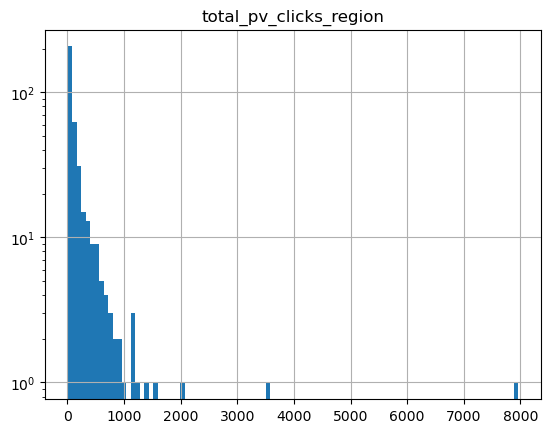

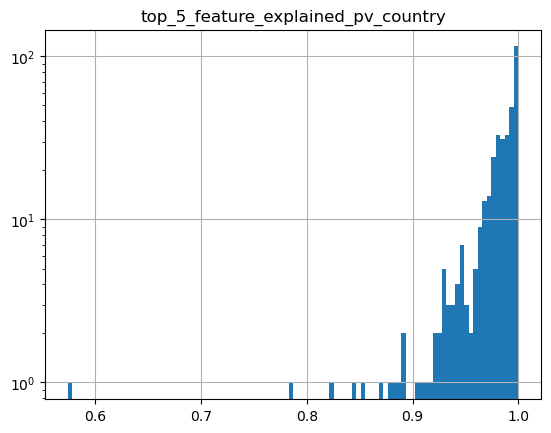

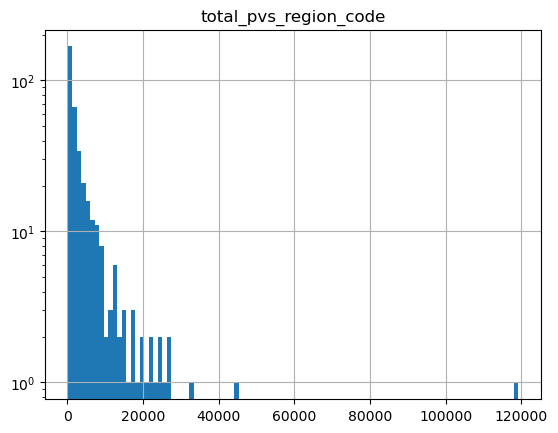

In [20]:
plt.figure(1)
publisher_features.hist(column=['total_pv_clicks_region'], bins= 100)
plt.yscale('log')

plt.figure(2)
publisher_features.hist(column=['top_5_feature_explained_pv_country'], bins= 100)
plt.yscale('log')

plt.figure(3)
publisher_features.hist(column=['total_pvs_region_code'], bins= 100)
plt.yscale('log')

In [27]:
publisher_features_normalized = publisher_features.copy()
explained_categories = ["country", "city", "region", "region_code", "upp_tax"]
exp_cats_num_features = ["top_5_feature_explained_pv_", "total_pvs_", "total_pv_clicks_"]
series_dict = {}
for cat in explained_categories:
    for feat in exp_cats_num_features:
        z_score = zscore(publisher_features_normalized[feat+cat])
        series_dict[feat+cat] = pd.Series(abs(z_score) <= 2.5)

import functools
filter_series = functools.reduce(lambda s1, s2: s1 & s2, series_dict.values())
publisher_features_normalized = publisher_features_normalized[filter_series]
publisher_features_normalized.shape

(333, 55)

<Figure size 640x480 with 0 Axes>

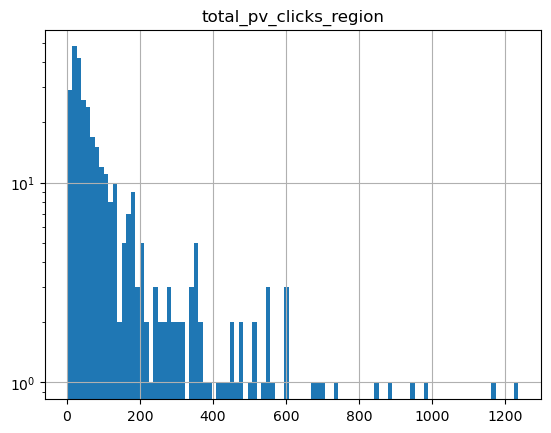

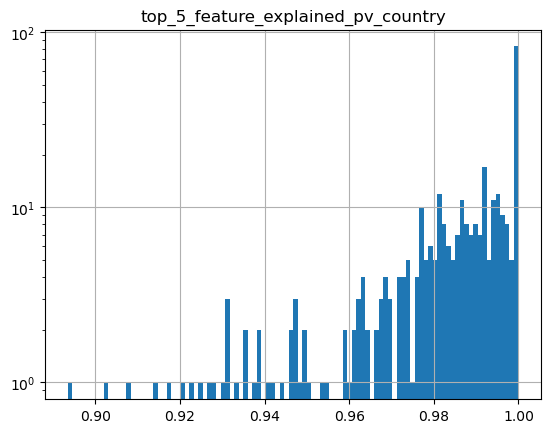

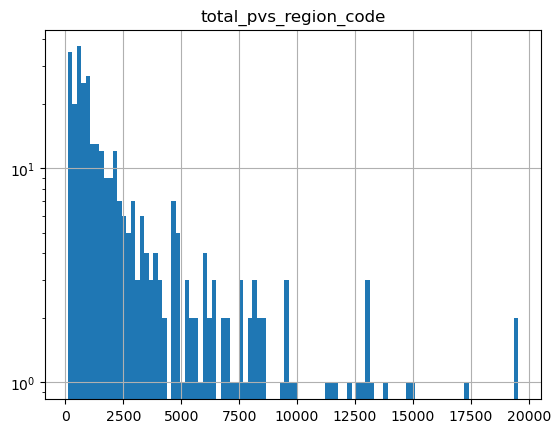

In [22]:
plt.figure(1)
publisher_features_normalized.hist(column=['total_pv_clicks_region'], bins= 100)
plt.yscale('log')

plt.figure(2)
publisher_features_normalized.hist(column=['top_5_feature_explained_pv_country'], bins= 100)
plt.yscale('log')

plt.figure(3)
publisher_features_normalized.hist(column=['total_pvs_region_code'], bins= 100)
plt.yscale('log')

# Visual 2D & 3D Projections

### full publisher features T-SNE

In [21]:
target = "common_publisher_target_taxonomy"

In [22]:
tsne = TSNE(n_components=3) 
tsne_components = tsne.fit_transform(publisher_features_dummies)

tsne_components_publisher_features_dummies = pd.DataFrame(data=tsne_components, columns=['PC1', 'PC2', 'PC3'])


c:\Users\ofri\anaconda3\envs\starship2.0\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\ofri\anaconda3\envs\starship2.0\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [23]:
lbe = LabelEncoder()
enc_target = lbe.fit_transform(publisher_features[target])
# enc_target = publisher_features[target]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


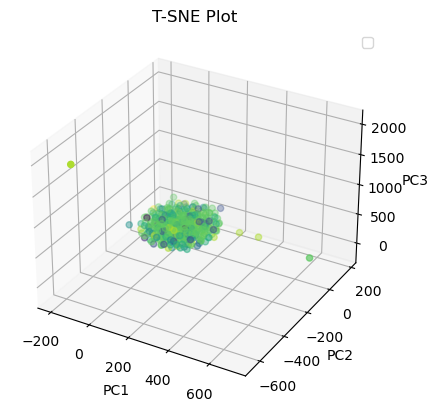

In [24]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(tsne_components_publisher_features_dummies.iloc[:, 0], tsne_components_publisher_features_dummies.iloc[:, 1], tsne_components_publisher_features_dummies.iloc[:, 2], c=enc_target)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('T-SNE Plot')
ax.legend()

# Show the plot
plt.show()

### full publisher features PCA

### PCA normed data

In [28]:
publisher_features_normed_dummies = pd.get_dummies(publisher_features_normalized.drop(["publisherId"], axis=1), columns=cat_publisher_features + ['top_taxonomy'])
scaler = MinMaxScaler()
publisher_features_dummies_normed_scaled = pd.DataFrame(scaler.fit_transform(publisher_features_normed_dummies), columns=publisher_features_normed_dummies.columns)

filtered_publisher_features = publisher_features[filter_series]

pca_2 = PCA(n_components=2)
pca_3 = PCA(n_components=3) 

twoD_components_normed = pca_2.fit_transform(publisher_features_dummies_normed_scaled)
threeD_components_normed = pca_3.fit_transform(publisher_features_dummies_normed_scaled)

twoD_components_normed = pd.DataFrame(data=twoD_components_normed, columns=['PC1', 'PC2'])
threeD_components_normed = pd.DataFrame(data=threeD_components_normed, columns=['PC1', 'PC2', 'PC3'])

In [36]:
threeD_components_normed["target"] = publisher_features_normalized["top_taxonomy"].reset_index(drop=True)
treed_2 = threeD_components_normed.query("target != 'VIRAL'")

# threeD_components_normed["target"] = dbs.labels_
fig = px.scatter_3d(treed_2, x='PC1', y='PC2', z='PC3',
              color='target')
fig.update_traces(showlegend=True)
fig.show()

In [83]:
twoD_components_normed["target"] = publisher_features_normalized["is_sp_lovers_publisher"].reset_index(drop=True)
# twoD_components_normed["target"] = dbs.labels_
fig = px.scatter(twoD_components_normed, x='PC1', y='PC2',
              color='target')
fig.update_traces(showlegend=True)
fig.show()

### PCA regular data

In [ ]:
pca_2 = PCA(n_components=2)
pca_3 = PCA(n_components=3) 

twoD_components = pca_2.fit_transform(publisher_features_dummies_scaled)
threeD_components = pca_3.fit_transform(publisher_features_dummies_scaled)

twoD_components = pd.DataFrame(data=twoD_components, columns=['PC1', 'PC2'])
threeD_components_df = pd.DataFrame(data=threeD_components, columns=['PC1', 'PC2', 'PC3'])

In [145]:
def plot_3d_cat_target(legend=True):

    unique_labels = np.unique(enc_target)
    num_categories = len(unique_labels)
    color_map = plt.cm.get_cmap('tab10', num_categories)

    fig = plt.figure(2)
    ax = fig.add_subplot(111, projection='3d')

    for i, label in enumerate(unique_labels):
        if label != 'None':
            indices = np.where(enc_target == label)[0]
            ax.scatter(threeD_components_df.iloc[indices, 0], 
                    threeD_components_df.iloc[indices, 1], 
                    threeD_components_df.iloc[indices, 2], 
                    label=label, c=color_map(i))

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title('3D PCA')
    if legend:
        ax.legend()
    # Show the plot
    plt.show()


def plot_3d_num_target():
    unique_labels = np.unique(enc_target)

    fig = plt.figure(2)
    ax = fig.add_subplot(111, projection='3d')

    for label in unique_labels:
        indices = np.where(enc_target == label)[0]
        ax.scatter(threeD_components_df.iloc[indices, 0], 
                threeD_components_df.iloc[indices, 1], 
                threeD_components_df.iloc[indices, 2], 
                label=label)

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title('3D PCA')
    ax.legend()

    # Show the plot
    plt.show()

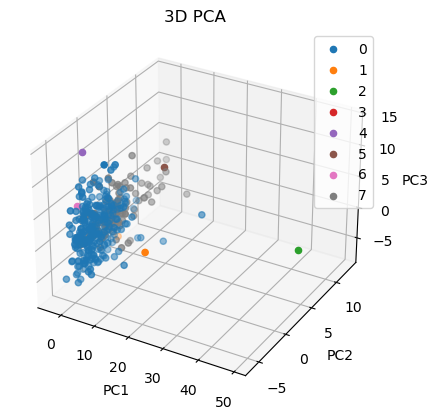

In [294]:
target = "is_sp_lovers_publisher"
enc_target = means8.labels_
plot_3d_num_target()

# Clustering Tryouts

In [31]:
def compute_compactness_and_seperation(data, clusters):

    intra_cluster_distances = []
    
    for cluster_id in np.unique(clusters):
        cluster_points = data[clusters == cluster_id]
        intra_cluster_distances.append(np.mean(euclidean_distances(cluster_points)))

    inter_cluster_distances = []
    for cluster_id1 in np.unique(clusters):
        for cluster_id2 in np.unique(clusters):
            if cluster_id1 != cluster_id2:
                cluster_points1 = data[clusters == cluster_id1]
                cluster_points2 = data[clusters == cluster_id2]
                min_distance = np.min(euclidean_distances(cluster_points1, cluster_points2))
                inter_cluster_distances.append(min_distance)

    compactness = np.mean(intra_cluster_distances)

    separation = np.min(inter_cluster_distances)

    print("Cluster Compactness:", compactness)
    print("Cluster Separation:", separation)

## DBscan

In [73]:
from sklearn.cluster import DBSCAN

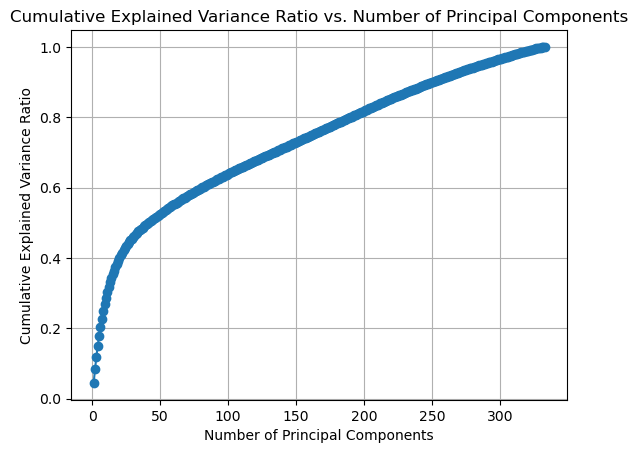

In [201]:
pca_try = PCA()

pca_try.fit(publisher_features_dummies_normed_scaled)

cumulative_explained_variance_ratio = np.cumsum(pca_try.explained_variance_ratio_)

plt.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Principal Components')
plt.grid(True)
plt.show()

In [74]:
pc = PCA(n_components=50)
df = pc.fit_transform(publisher_features_dummies_normed_scaled)


In [81]:

dbs = DBSCAN(eps=2, min_samples=5)
dbs.fit(df)

DBSCAN(eps=2)

In [82]:
dbs.labels_

array([ 0,  0,  0,  1,  0,  1,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,
       -1,  0, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  3, -1, -1, -1,  0,
        1,  0, -1,  0, -1, -1,  0, -1, -1, -1, -1, -1,  0,  2, -1,  0,  4,
       -1,  1, -1,  0, -1, -1, -1, -1, -1,  3, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1,  0,  0, -1,  0,  0,  0,  1,  0,  1, -1,  0,  0, -1,
        0, -1,  0, -1,  3,  0, -1, -1, -1,  0, -1,  1,  0,  0, -1,  0,  0,
       -1,  2,  0, -1,  3, -1,  0,  0,  0, -1, -1, -1, -1,  0,  0, -1,  1,
       -1,  0,  0,  0,  3, -1, -1,  0, -1, -1, -1, -1, -1,  0,  3, -1, -1,
        1,  1,  1, -1,  0,  0,  0, -1, -1,  0, -1, -1, -1, -1, -1,  0,  0,
       -1, -1,  0,  0, -1, -1,  0,  0, -1,  0, -1, -1,  4, -1,  0,  1,  1,
       -1,  0, -1, -1, -1, -1,  4, -1,  0, -1, -1, -1, -1, -1, -1,  1,  1,
       -1,  0, -1, -1, -1, -1,  0, -1,  0,  0,  0, -1,  0,  0, -1, -1, -1,
       -1,  0, -1,  0,  0, -1,  0,  3,  0, -1, -1, -1,  0, -1,  0,  0,  1,
        0,  0,  1,  1, -1

## K-means

In [293]:
means8 = KMeans(8)
means8.fit(publisher_features_dummies_scaled)

KMeans()

In [126]:
means15 = KMeans(15)
means15.fit(publisher_features_dummies_scaled)

means10 = KMeans(10)
means10.fit(publisher_features_dummies_scaled)

means7 = KMeans(7)
means7.fit(publisher_features_dummies_scaled)

means5 = KMeans(5)
means5.fit(publisher_features_dummies_scaled)

KMeans(n_clusters=5)

In [157]:
print("5-Means Inertia:", means5.inertia_)
print("7-Means Inertia:", means7.inertia_)
print("10-Means Inertia:", means10.inertia_)
print("15-Means Inertia:", means15.inertia_)

print("#################")

print("5-Means Silhouette Score:", silhouette_score(publisher_features_dummies_scaled, means5.labels_))
print("7-Means Silhouette Score:", silhouette_score(publisher_features_dummies_scaled, means7.labels_))
print("10-Means Silhouette Score:", silhouette_score(publisher_features_dummies_scaled, means10.labels_))
print("15-Means Silhouette Score:", silhouette_score(publisher_features_dummies_scaled, means15.labels_))

print("#################")

print("5-Means Davies-Bouldin Score:", davies_bouldin_score(publisher_features_dummies_scaled, means5.labels_))
print("7-Means Davies-Bouldin Score:", davies_bouldin_score(publisher_features_dummies_scaled, means7.labels_))
print("10-Means Davies-Bouldin Score:", davies_bouldin_score(publisher_features_dummies_scaled, means10.labels_))
print("15-Means Davies-Bouldin Score:", davies_bouldin_score(publisher_features_dummies_scaled, means15.labels_))

print("#################")

print("5-Means Calinski-Harabasz Score:", calinski_harabasz_score(publisher_features_dummies_scaled, means5.labels_))
print("7-Means Calinski-Harabasz Score:", calinski_harabasz_score(publisher_features_dummies_scaled, means7.labels_))
print("10-Means Calinski-Harabasz Score:", calinski_harabasz_score(publisher_features_dummies_scaled, means10.labels_))
print("15-Means Calinski-Harabasz Score:", calinski_harabasz_score(publisher_features_dummies_scaled, means15.labels_))

5-Means Inertia: 742827.7850381109
7-Means Inertia: 738388.8007695238
10-Means Inertia: 731660.5797637382
15-Means Inertia: 718743.8215355873
#################
5-Means Silhouette Score: -0.005250536831717895
7-Means Silhouette Score: -0.02698031372675563
10-Means Silhouette Score: -0.03643819690065051
15-Means Silhouette Score: -0.027934377595834482
#################
5-Means Davies-Bouldin Score: 2.6135573515694555
7-Means Davies-Bouldin Score: 2.3569083350008087
10-Means Davies-Bouldin Score: 1.3241032739784295
15-Means Davies-Bouldin Score: 3.3971516045981343
#################
5-Means Calinski-Harabasz Score: 1.247522967527707
7-Means Calinski-Harabasz Score: 1.1978350054404585
10-Means Calinski-Harabasz Score: 1.1691526460432105
15-Means Calinski-Harabasz Score: 1.212805626600138


In [162]:
import os
os.environ['OMP_NUM_THREADS'] = '2'

best_performences = {'min_inertia':float('inf'), 'min_inertia_k': 0, 'max_sil_score': -1.1, 'max_sil_k': 0 , 'min_db_score': float('inf'), 'min_db_k' : 0, 'max_ch_score': 0.0, 'max_ch_k' : 0}
for i in range(2,30):
    kmeans = KMeans(i)
    kmeans.fit(publisher_features_dummies_scaled)
    inertia = kmeans.inertia_
    sil_score = silhouette_score(publisher_features_dummies_scaled, kmeans.labels_)
    db_score = davies_bouldin_score(publisher_features_dummies_scaled, kmeans.labels_)
    ch_score = calinski_harabasz_score(publisher_features_dummies_scaled, kmeans.labels_)
    if inertia < best_performences["min_inertia"]:
        best_performences['min_inertia'] = inertia
        best_performences["min_inertia_k"] = i
    if sil_score > best_performences["max_sil_score"]:
        best_performences['max_sil_score'] = sil_score
        best_performences["max_sil_k"] = i
    if db_score < best_performences["min_db_score"]:
        best_performences['min_db_score'] = db_score
        best_performences["min_db_k"] = i
    if ch_score > best_performences["max_ch_score"]:
        best_performences['max_ch_score'] = ch_score
        best_performences["max_ch_k"] = i

print(best_performences)

{'min_inertia': 686575.0994451565, 'min_inertia_k': 29, 'max_sil_score': -0.00042231464775600066, 'max_sil_k': 2, 'min_db_score': 1.1542443165057843, 'min_db_k': 8, 'max_ch_score': 1.5428310806962942, 'max_ch_k': 2}


In [246]:

def top_centroids_variance_features(centroids, N=5):
    feature_variances = np.var(centroids, axis=0)

    top_feature_indices = np.argsort(feature_variances)[::-1][:N]
    top_feature_names = scaled_pub_df.columns[top_feature_indices]

    top_feature_variances = feature_variances[top_feature_indices]

    # Plot bar plot of the variances of the top N features
    plt.figure(figsize=(10, 6))
    plt.bar(top_feature_names, top_feature_variances, color='skyblue')
    plt.ylabel('Variance')
    plt.xlabel('Feature')
    plt.title(f'Top {N} Features with Largest Variances of Centroids')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.show()

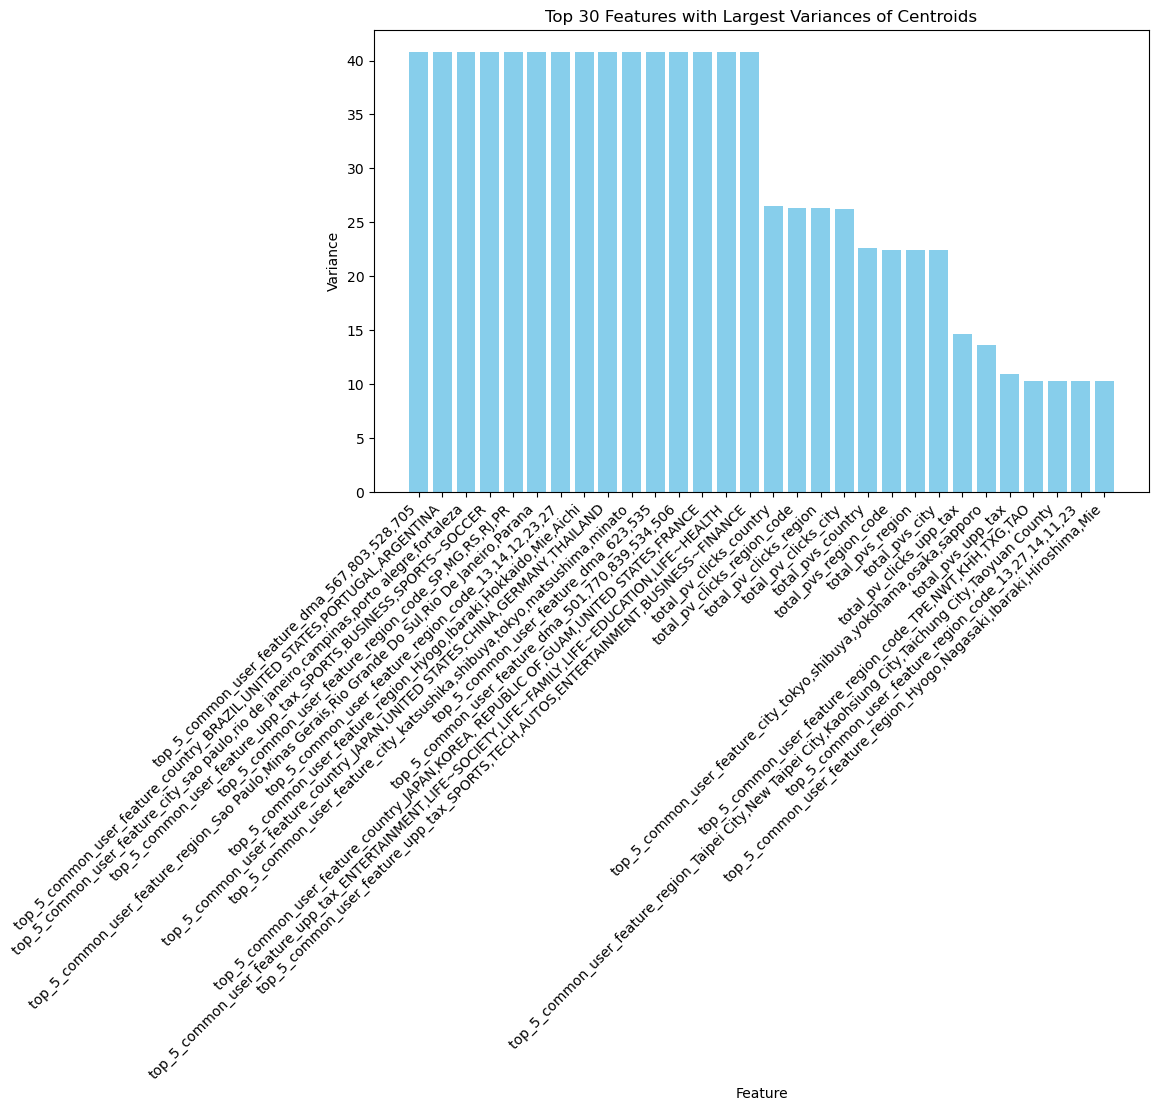

In [239]:
# means8 = KMeans(8)
# means8.fit(publisher_features_dummies_scaled)
# eight_means_centroids = means8.cluster_centers_
# top_cluster_variance_features(eight_means_centroids, 30)
means8 = KMeans(8)
means8.fit(publisher_features_dummies_scaled)
eight_means_centroids = means8.cluster_centers_
top_centroids_variance_features(eight_means_centroids, 30)

### cluster the data embeddings

In [256]:
input_dim = publisher_features_dummies_scaled.shape[1]  # Input dimensionality
encoding_dim = 100  # Dimensionality of the latent space (embedding)

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)

# Create the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder on your dataset
autoencoder.fit(publisher_features_dummies_scaled, publisher_features_dummies_scaled, epochs=100, batch_size=32, shuffle=True)

# Extract embeddings (latent space representations)
encoder_model = Model(inputs=input_layer, outputs=encoder)
embeddings = encoder_model.predict(publisher_features_dummies_scaled)

Train on 372 samples
Epoch 1/100
372/372 [==============================] - 0s 1ms/sample - loss: 1.2014
Epoch 2/100
372/372 [==============================] - 0s 147us/sample - loss: 1.0649
Epoch 3/100
372/372 [==============================] - 0s 149us/sample - loss: 1.0021
Epoch 4/100
372/372 [==============================] - 0s 157us/sample - loss: 0.9923
Epoch 5/100
372/372 [==============================] - 0s 171us/sample - loss: 0.9880
Epoch 6/100
372/372 [==============================] - 0s 189us/sample - loss: 0.9825
Epoch 7/100
372/372 [==============================] - 0s 219us/sample - loss: 0.9750
Epoch 8/100
372/372 [==============================] - 0s 192us/sample - loss: 0.9660
Epoch 9/100
372/372 [==============================] - 0s 176us/sample - loss: 0.9559
Epoch 10/100
372/372 [==============================] - 0s 190us/sample - loss: 0.9455
Epoch 11/100
372/372 [==============================] - 0s 187us/sample - loss: 0.9354
Epoch 12/100
372/372 [===========

In [266]:
min_db_score = float('inf')
min_db_k = 0
for i in range(2, 21):
    embedded_Kmeans = KMeans(n_clusters=i)
    embedded_Kmeans.fit(embeddings)
    db_score = davies_bouldin_score(embeddings, embedded_Kmeans.labels_)
    if db_score < min_db_score:
        min_db_score = db_score
        min_db_k = i

embedded_Kmeans = KMeans(n_clusters=min_db_k)
embedded_Kmeans.fit(embeddings)
print(min_db_k)

20


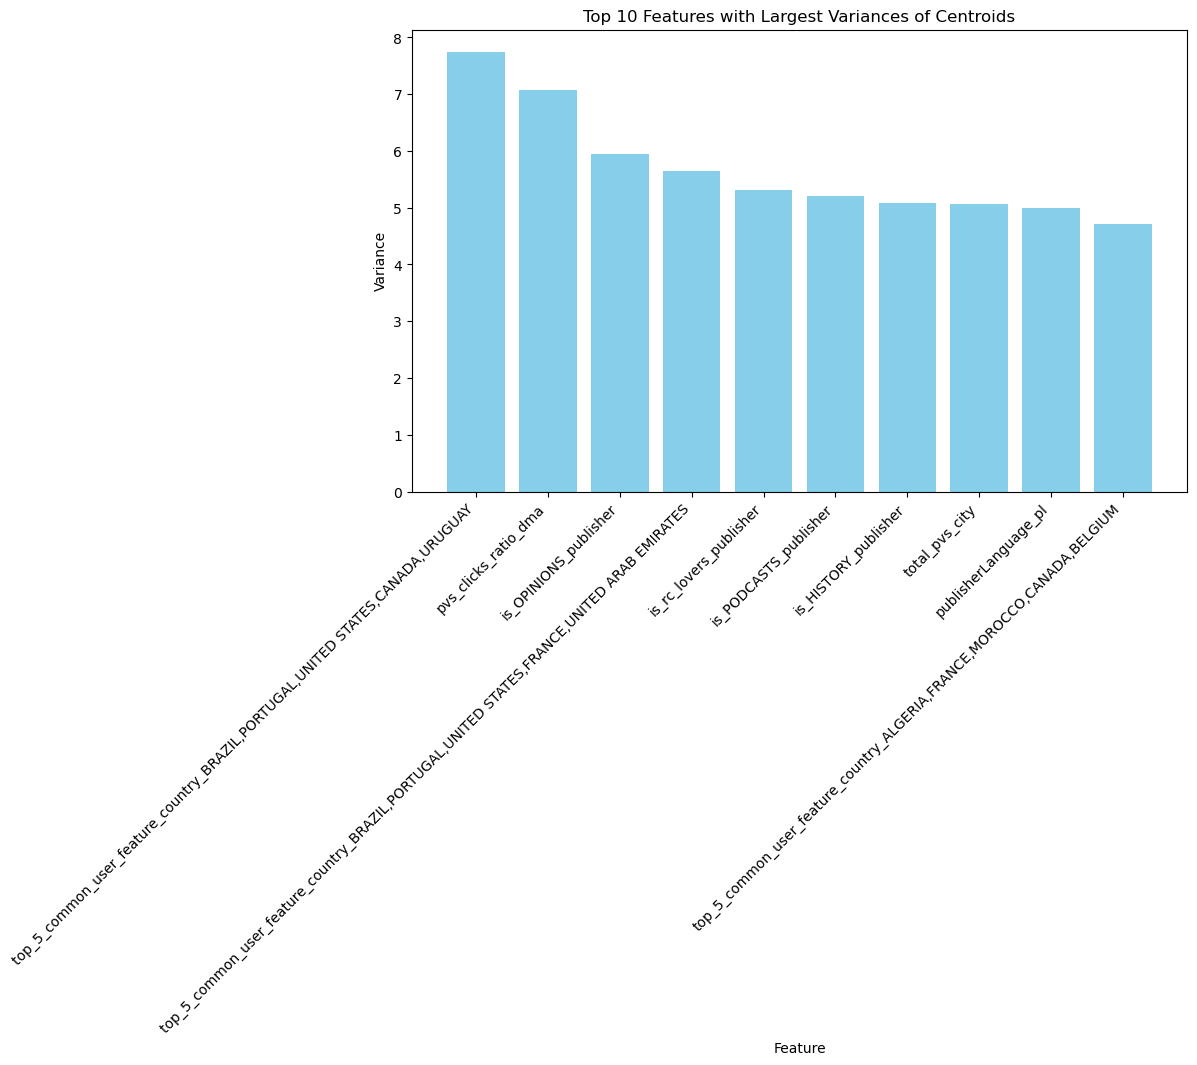

In [267]:
emb_kmeans_centroids = embedded_Kmeans.cluster_centers_
top_centroids_variance_features(emb_kmeans_centroids, 10)

In [268]:
cosine_sim_matrix = pairwise_distances(embeddings, metric='cosine')

n_clusters = 8

spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
cluster_labels = spectral_clustering.fit_predict(cosine_sim_matrix)

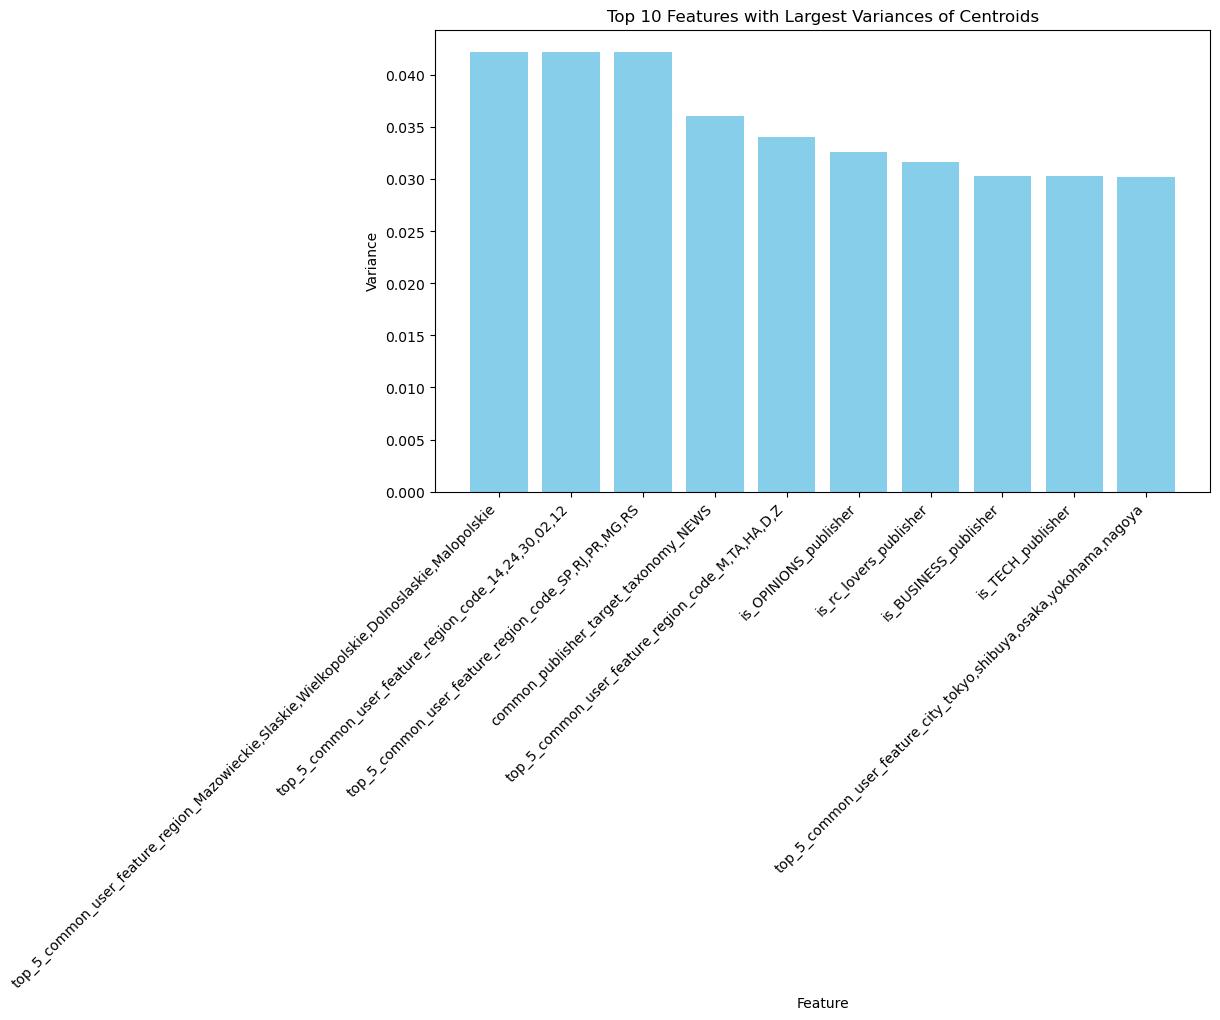

In [270]:
scaled_pub_df['spectral_cluster'] = spectral_clustering.labels_
spec_centroids = scaled_pub_df.groupby('spectral_cluster').mean()
top_centroids_variance_features(spec_centroids, 10)

# Feature embeddings

## Taxonomy classification model embedddings

In [32]:
from sklearn.utils.class_weight import compute_class_weight

In [25]:
def extract_top_taxonomy(row):
    top_5_tax = row["top_5_common_user_feature_upp_tax"]
    comma_idx = top_5_tax.find(',')
    tilda_idx = top_5_tax.find('~')
    if comma_idx == tilda_idx == -1:
        return top_5_tax
    if comma_idx == -1 or tilda_idx == -1:
        return top_5_tax[:max(comma_idx, tilda_idx)]
    return top_5_tax[:min(comma_idx, tilda_idx)]


publisher_features_normalized["top_taxonomy"] = publisher_features_normalized.apply(extract_top_taxonomy, axis=1)


In [33]:
publisher_features_normalized["top_taxonomy"].value_counts()

NEWS             112
ENTERTAINMENT     70
SPORTS            50
LIFE              48
TECH              17
BUSINESS          17
INDIA              8
AUTOS              6
OPINIONS           4
VIRAL              1
Name: top_taxonomy, dtype: int64

In [104]:
classification_data = publisher_features_normalized.copy()
classification_data = classification_data.drop(['is_NEWS_publisher', 'is_ENTERTAINMENT_publisher', 'is_LIFE_publisher',
       'is_SPORTS_publisher', 'is_BUSINESS_publisher', 'is_TECH_publisher',
       'is_OPINIONS_publisher', 'is_INDIA_publisher', 'is_AUTOS_publisher',
       'is_VIRAL_publisher', 'is_ENVIRONMENT_publisher', 'is_HUMOR_publisher',
       'is_HISTORY_publisher', 'is_TOP-NEWS_publisher',
       'is_OBSOLETE_publisher', 'is_PODCASTS_publisher','top_5_common_user_feature_upp_tax',
       'top_5_feature_explained_pv_upp_tax', 'total_pvs_upp_tax',
       'total_pv_clicks_upp_tax', 'pvs_clicks_ratio_upp_tax', 'common_publisher_target_taxonomy', 'publisherId'], axis=1)

classification_data = classification_data[classification_data["top_taxonomy"] != "VIRAL"]
classification_labels = classification_data["top_taxonomy"]
classification_data = classification_data.drop(["top_taxonomy"], axis=1)

cat_publisher_features_classification = ["publisherLanguage", 'top_5_common_user_feature_country','top_5_common_user_feature_region','top_5_common_user_feature_region_code','top_5_common_user_feature_city', 'top_5_common_user_feature_dma']
classification_data = pd.get_dummies(classification_data, columns=cat_publisher_features_classification)
scaler = MinMaxScaler()
classification_data = scaler.fit_transform(classification_data)

lbe = LabelEncoder()
classification_labels_encoded = lbe.fit_transform(classification_labels)

In [106]:
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

In [280]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(classification_labels), y=classification_labels)

class_weight_dict = dict(enumerate(class_weights))

classification_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation=gelu, input_shape=(1476,)),
    tf.keras.layers.Dense(32, activation=gelu),
    tf.keras.layers.Dense(9, activation='softmax')  
])

classification_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'], class_weight=class_weight_dict)


classification_model.fit(classification_data, classification_labels_encoded, epochs=15, batch_size=32)

Train on 332 samples
Epoch 1/15
332/332 [==============================] - 0s 1ms/sample - loss: 2.1541 - accuracy: 0.2199
Epoch 2/15
332/332 [==============================] - 0s 55us/sample - loss: 2.0266 - accuracy: 0.4518
Epoch 3/15
332/332 [==============================] - 0s 72us/sample - loss: 1.8861 - accuracy: 0.4367
Epoch 4/15
332/332 [==============================] - 0s 74us/sample - loss: 1.7393 - accuracy: 0.4548
Epoch 5/15
332/332 [==============================] - 0s 73us/sample - loss: 1.6053 - accuracy: 0.4036
Epoch 6/15
332/332 [==============================] - 0s 69us/sample - loss: 1.4780 - accuracy: 0.4217
Epoch 7/15
332/332 [==============================] - 0s 63us/sample - loss: 1.3155 - accuracy: 0.6205
Epoch 8/15
332/332 [==============================] - 0s 59us/sample - loss: 1.1189 - accuracy: 0.7681
Epoch 9/15
332/332 [==============================] - 0s 69us/sample - loss: 0.8904 - accuracy: 0.8373
Epoch 10/15
332/332 [==============================] 

In [281]:

embedding_model = tf.keras.Model(inputs=classification_model.input, outputs=classification_model.layers[-2].output)



In [282]:

clssification_embeddings = embedding_model.predict(classification_data)

# 'embeddings' will contain the embeddings for your data
print("Embeddings shape:", clssification_embeddings.shape)

Embeddings shape: (332, 32)


c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



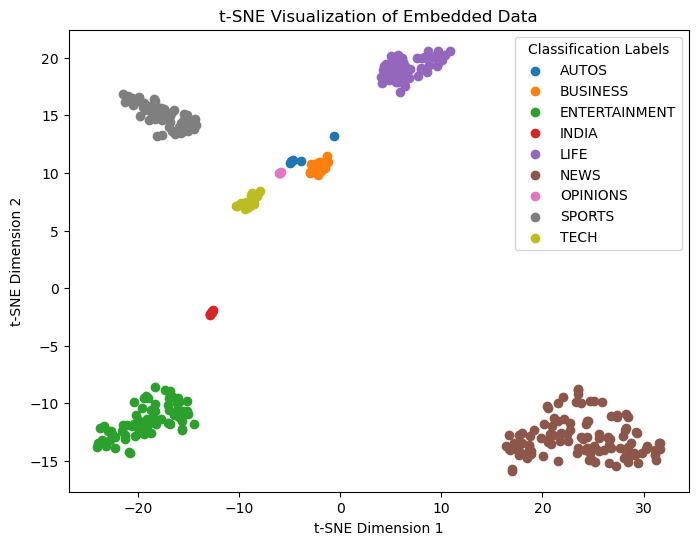

In [283]:
# Assuming classification_labels is a list or array of strings representing labels
# Convert labels to integers for plotting
label_to_int = {label: idx for idx, label in enumerate(np.unique(classification_labels))}
classification_labels_int = np.array([label_to_int[label] for label in classification_labels])

# Step 1: Reduce the dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(clssification_embeddings)

# Step 2: Plot the reduced data with colors representing labels and add a legend
plt.figure(figsize=(8, 6))
for label, label_int in label_to_int.items():
    plt.scatter(tsne_data[classification_labels_int == label_int, 0], 
                tsne_data[classification_labels_int == label_int, 1], 
                label=label)
plt.title('t-SNE Visualization of Embedded Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Classification Labels')
plt.show()

In [274]:
tsne_data_df = pd.DataFrame(tsne_data, columns=['t-sne dim 1', 't-sne dim 2'])
# tsne_data_df["target"] = classification_labels.reset_index(drop=True)
tsne_data_df["target"] = means5.labels_

px.scatter(tsne_data_df, x='t-sne dim 1', y='t-sne dim 2', color="target")

In [99]:
pca_emb = PCA(n_components=3)
pca_embbeddings = pca_emb.fit_transform(clssification_embeddings)

In [136]:
threeD_components_emb = pd.DataFrame(data=pca_embbeddings, columns=['PC1', 'PC2', 'PC3'])
threeD_components_emb["Top Taxonomy"] = classification_labels.reset_index(drop=True)

# threeD_components_normed["target"] = dbs.labels_
fig = px.scatter_3d(threeD_components_emb, x='PC1', y='PC2', z='PC3',
              color='Top Taxonomy', title='Publisher Embeddings')
fig.update_traces(showlegend=True)
fig.show()

In [50]:
means5 = KMeans(5)
means5.fit(clssification_embeddings)

KMeans(n_clusters=5)

In [54]:
compute_compactness_and_seperation(clssification_embeddings, means5.labels_)

Cluster Compactness: 1.2586172
Cluster Separation: 0.44633496


## CTR prediction embeddings

In [132]:
from deepctr.models import DeepFM

In [130]:
from deepctr.feature_column import SparseFeat, DenseFeat,get_feature_names
from sklearn.model_selection import train_test_split

In [61]:
data = merged_df[["publisherLanguage", 'top_5_common_user_feature_country',
       'top_5_feature_explained_pv_country', 'total_pvs_country',
       'total_pv_clicks_country', 'top_5_common_user_feature_region',
       'top_5_feature_explained_pv_region', 'total_pvs_region',
       'total_pv_clicks_region', 'top_5_common_user_feature_region_code',
       'top_5_feature_explained_pv_region_code', 'total_pvs_region_code',
       'total_pv_clicks_region_code', 'top_5_common_user_feature_city',
       'top_5_feature_explained_pv_city', 'total_pvs_city',
       'total_pv_clicks_city', 'top_5_common_user_feature_upp_tax',
       'top_5_feature_explained_pv_upp_tax', 'total_pvs_upp_tax',
       'total_pv_clicks_upp_tax', 'top_5_common_user_feature_dma',
       'top_5_feature_explained_pv_dma', 'total_pvs_dma',
       'total_pv_clicks_dma',
       'is_NEWS_publisher', 'is_ENTERTAINMENT_publisher', 'is_LIFE_publisher',
       'is_SPORTS_publisher', 'is_BUSINESS_publisher', 'is_TECH_publisher',
       'is_OPINIONS_publisher', 'is_INDIA_publisher', 'is_AUTOS_publisher',
       'is_VIRAL_publisher', 'is_ENVIRONMENT_publisher', 'is_HUMOR_publisher',
       'is_HISTORY_publisher', 'is_TOP-NEWS_publisher',
       'is_OBSOLETE_publisher', 'is_PODCASTS_publisher',
       'pvs_clicks_ratio_country', 'pvs_clicks_ratio_region',
       'pvs_clicks_ratio_region_code', 'pvs_clicks_ratio_city',
       'pvs_clicks_ratio_upp_tax', 'pvs_clicks_ratio_dma', 'is_sp_lovers_publisher', 'is_rc_lovers_publisher', 'common_publisher_target_taxonomy', 'clicks']]

sparse_features = ["publisherLanguage", 'top_5_common_user_feature_country', 'top_5_common_user_feature_region', 'top_5_common_user_feature_region_code', 'top_5_common_user_feature_region_code',\
                   'top_5_common_user_feature_city', 'top_5_common_user_feature_upp_tax', 'top_5_common_user_feature_dma','common_publisher_target_taxonomy']
dense_features = set(data.columns).difference(sparse_features + ['clicks'])

target = ['clicks']

In [62]:
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = data[feat].astype('str')
    data[feat] = lbe.fit_transform(data[feat])
    
dense_features = list(dense_features)
mms = MinMaxScaler(feature_range=(0,1))
data[dense_features] = mms.fit_transform(data[dense_features])

c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [63]:
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].max() + 1,embedding_dim=20)
                       for i,feat in enumerate(sparse_features)] + [DenseFeat(feat, 1,)
                      for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [64]:
train, test = train_test_split(data, test_size=0.2, shuffle=False)

train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}


model = DeepFM(linear_feature_columns,dnn_feature_columns,task='binary')
model.compile("adam", "binary_crossentropy",
              metrics=['binary_crossentropy'] )

In [65]:
class_distribution_DFM = train[target].value_counts()

cls_weights_DFM = {1: class_distribution_DFM[0] / (class_distribution_DFM[0] + class_distribution_DFM[1]),
               0: class_distribution_DFM[1] / (class_distribution_DFM[0] + class_distribution_DFM[1])}

In [66]:
history = model.fit(train_model_input, train[target].values,
                    batch_size=256, class_weight=cls_weights_DFM, epochs=4, verbose=2, validation_split=0.2,shuffle=False )

Train on 1119314 samples, validate on 279829 samples
Epoch 1/4


c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



1119314/1119314 - 42s - loss: 0.1224 - binary_crossentropy: 0.6685 - val_loss: 0.1300 - val_binary_crossentropy: 0.5540
Epoch 2/4
1119314/1119314 - 49s - loss: 0.1219 - binary_crossentropy: 0.6651 - val_loss: 0.1294 - val_binary_crossentropy: 0.5748
Epoch 3/4
1119314/1119314 - 60s - loss: 0.1219 - binary_crossentropy: 0.6650 - val_loss: 0.1300 - val_binary_crossentropy: 0.5671
Epoch 4/4
1119314/1119314 - 38s - loss: 0.1218 - binary_crossentropy: 0.6648 - val_loss: 0.1296 - val_binary_crossentropy: 0.5712


In [90]:
def get_embedding_output(model, input_data):
    # embedding layer is -9
    embedding_layer = model.layers[-9]

    embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)

    embedding_output = embedding_model.predict(input_data)

    return embedding_output

In [134]:
unique_data = merged_df[["publisherId", "publisherLanguage", 'top_5_common_user_feature_country',
       'top_5_feature_explained_pv_country', 'total_pvs_country',
       'total_pv_clicks_country', 'top_5_common_user_feature_region',
       'top_5_feature_explained_pv_region', 'total_pvs_region',
       'total_pv_clicks_region', 'top_5_common_user_feature_region_code',
       'top_5_feature_explained_pv_region_code', 'total_pvs_region_code',
       'total_pv_clicks_region_code', 'top_5_common_user_feature_city',
       'top_5_feature_explained_pv_city', 'total_pvs_city',
       'total_pv_clicks_city', 'top_5_common_user_feature_upp_tax',
       'top_5_feature_explained_pv_upp_tax', 'total_pvs_upp_tax',
       'total_pv_clicks_upp_tax', 'top_5_common_user_feature_dma',
       'top_5_feature_explained_pv_dma', 'total_pvs_dma',
       'total_pv_clicks_dma',
       'is_NEWS_publisher', 'is_ENTERTAINMENT_publisher', 'is_LIFE_publisher',
       'is_SPORTS_publisher', 'is_BUSINESS_publisher', 'is_TECH_publisher',
       'is_OPINIONS_publisher', 'is_INDIA_publisher', 'is_AUTOS_publisher',
       'is_VIRAL_publisher', 'is_ENVIRONMENT_publisher', 'is_HUMOR_publisher',
       'is_HISTORY_publisher', 'is_TOP-NEWS_publisher',
       'is_OBSOLETE_publisher', 'is_PODCASTS_publisher',
       'pvs_clicks_ratio_country', 'pvs_clicks_ratio_region',
       'pvs_clicks_ratio_region_code', 'pvs_clicks_ratio_city',
       'pvs_clicks_ratio_upp_tax', 'pvs_clicks_ratio_dma', 'is_sp_lovers_publisher', 'is_rc_lovers_publisher', 'common_publisher_target_taxonomy', 'clicks']]

unique_data = unique_data.drop_duplicates(subset=["publisherId"])
unique_data = unique_data.drop(["publisherId"], axis=1)

unique_data_top_taxonomies = unique_data.apply(extract_top_taxonomy,axis=1)

for feat in sparse_features:
    lbe = LabelEncoder()
    unique_data[feat] = unique_data[feat].astype('str')
    unique_data[feat] = lbe.fit_transform(unique_data[feat])
    
dense_features = list(dense_features)
mms = MinMaxScaler(feature_range=(0,1))
unique_data[dense_features] = mms.fit_transform(unique_data[dense_features])

fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=unique_data[feat].max() + 1,embedding_dim=20)
                       for i,feat in enumerate(sparse_features)] + [DenseFeat(feat, 1,)
                      for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

unique_input_data = {name:unique_data[name].values for name in feature_names}


In [135]:
embedding_output = get_embedding_output(model, unique_input_data)

In [136]:
ctr_tsne = TSNE(n_components=2, random_state=42)
ctr_tsne_data = ctr_tsne.fit_transform(embedding_output)

c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [160]:
ctr_tsne_data_df = pd.DataFrame(ctr_tsne_data, columns=['t-sne dim 1', 't-sne dim 2'])
ctr_tsne_data_df["target"] = unique_data["clicks"].reset_index(drop=True).astype('category')
# ctr_tsne_data_df["target"] = unique_data_top_taxonomies.reset_index(drop=True).astype('category')


fig = px.scatter(ctr_tsne_data_df, x='t-sne dim 1', y='t-sne dim 2', color="target", 
                 title="t-SNE Visualization of Embedded Data")
fig.update_layout(legend_title_text="Clicks")

fig.show()

## Shared Users Graph Clustering

In [55]:
from community import community_louvain

In [260]:
G = nx.Graph()

# Group by publisherId and aggregate userIds into sets
publisher_users = merged_df.groupby('publisherId')['userId'].agg(set)

# Iterate over pairs of publishers
for publisher1, users1 in publisher_users.items():
    for publisher2, users2 in publisher_users.items():
        if publisher1 != publisher2:  # Avoid self-loops
            shared_users = len(users1 & users2)  # Intersection of user sets
            if shared_users > 0:
                G.add_edge(publisher1, publisher2, weight=shared_users)

In [ ]:
nx.write_graphml(G, "shared users graph.graphml")

In [56]:
G = nx.read_graphml("./shared users graph.graphml")

In [151]:
partition = community_louvain.best_partition(G)

In [61]:
partition_dict = {"publisherId":partition.keys(), "louvain_cluster": partition.values()}
graph_clustering_df = pd.DataFrame(partition_dict)

In [63]:
publishers_graph_clustered = pd.merge(publisher_features, graph_clustering_df, on="publisherId")

In [56]:
pca3_full_data = PCA(n_components=3)
full_data_3d_components = pca3_full_data.fit_transform(publisher_features_dummies_scaled)
full_data_3d_components = pd.DataFrame(data=full_data_3d_components, columns=['PC1', 'PC2', 'PC3'])

pca2_full_data = PCA(n_components=2)
full_data_2d_components = pca2_full_data.fit_transform(publisher_features_dummies_scaled)
full_data_2d_components = pd.DataFrame(data=full_data_2d_components, columns=['PC1', 'PC2'])

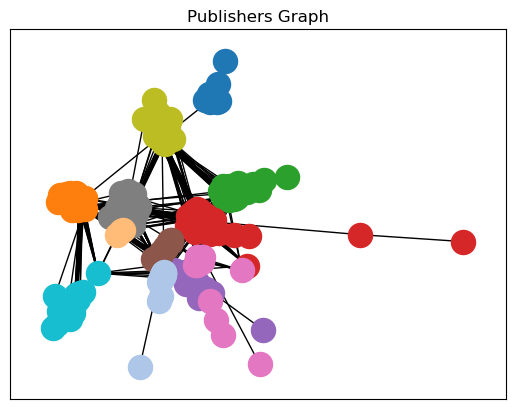

In [180]:
colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a'
]

pos = nx.spring_layout(G)  # Define layout for better visualization
for cluster in set(partition.values()):
    nodes_in_cluster = [node for node, c in partition.items() if c == cluster]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_in_cluster, node_color=colors[cluster])

nx.draw_networkx_edges(G, pos)  # Draw edges

plt.title("Publishers Graph")
plt.show()

In [173]:
G1 = G.copy()

threshold = 3

for node in list(G1.nodes()):
    if sum(weight for _, _, weight in G1.edges(node, data='weight')) < threshold:
        G1.remove_node(node)

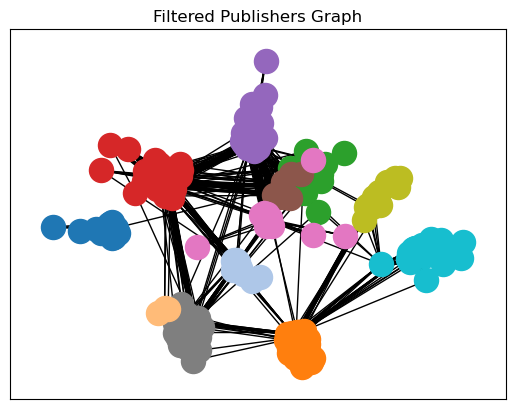

In [184]:
partition1 = community_louvain.best_partition(G1)

pos = nx.spring_layout(G1) 
for cluster in set(partition1.values()):
    nodes_in_cluster = [node for node, c in partition1.items() if c == cluster]
    nx.draw_networkx_nodes(G1, pos, nodelist=nodes_in_cluster, node_color=colors[cluster])

nx.draw_networkx_edges(G1, pos) 

plt.title("Filtered Publishers Graph")
plt.show()

In [187]:
cluster_to_publishers = {}
for id, cluster in partition1.items():
    cluster_to_publishers.setdefault(cluster, []).append(id)
for cluster, pubs in cluster_to_publishers.items():
    cluster_to_publishers[cluster] = pd.DataFrame(cluster_to_publishers[cluster], columns=["publisherId"])

In [207]:
publishers0 = pd.merge(publisher_features, cluster_to_publishers[0], on="publisherId")
publishers1 = pd.merge(publisher_features, cluster_to_publishers[1], on="publisherId")
publishers2 = pd.merge(publisher_features, cluster_to_publishers[2], on="publisherId")
publishers3 = pd.merge(publisher_features, cluster_to_publishers[3], on="publisherId")
publishers4 = pd.merge(publisher_features, cluster_to_publishers[4], on="publisherId")
publishers5 = pd.merge(publisher_features, cluster_to_publishers[5], on="publisherId")
publishers6 = pd.merge(publisher_features, cluster_to_publishers[6], on="publisherId")
publishers7 = pd.merge(publisher_features, cluster_to_publishers[7], on="publisherId")
publishers8 = pd.merge(publisher_features, cluster_to_publishers[8], on="publisherId")
publishers9 = pd.merge(publisher_features, cluster_to_publishers[9], on="publisherId")
publishers10 = pd.merge(publisher_features, cluster_to_publishers[10], on="publisherId")
publishers11 = pd.merge(publisher_features, cluster_to_publishers[11], on="publisherId")

In [224]:
publishers11[["publisherLanguage", "top_taxonomy"]]

,publisherLanguage,top_taxonomy
0,pt,NEWS
1,pt,ENTERTAINMENT
2,pt,ENTERTAINMENT


In [234]:
from sklearn.preprocessing import normalize

In [241]:
def spectral_clustering(G, k_eign, k_clusters):
    laplacian = nx.laplacian_matrix(G).toarray()
    
    eig_values, eig_vectors = np.linalg.eigh(laplacian)
    indices = np.argsort(eig_values)[:k_eign]
    first_k_eig_vectors = eig_vectors[:, indices]
    
    norm_first_k_eig_vectors = normalize(first_k_eig_vectors)
    
    kmeans = KMeans(n_clusters=k_clusters)
    clusters = kmeans.fit_predict(norm_first_k_eig_vectors)
    
    return clusters

In [242]:
clusters = spectral_clustering(G1, k_eign=20, k_clusters=15)

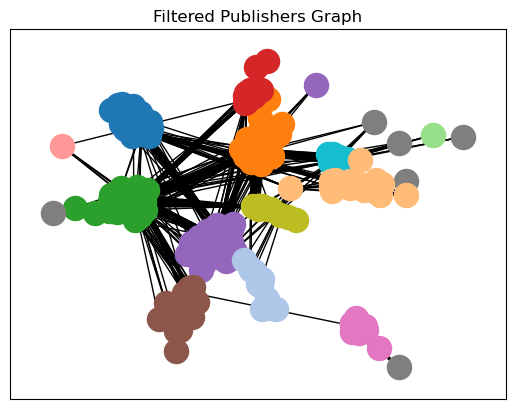

In [252]:
partition2 = dict(zip(list(G1.nodes), clusters))

colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#9467bd',
    '#c5b0d5', '#8c564b', '#c49c94', '#ff9896', '#c49c94'
]

pos = nx.spring_layout(G1) 
for cluster in set(partition2.values()):
    nodes_in_cluster = [node for node, c in partition2.items() if c == cluster]
    nx.draw_networkx_nodes(G1, pos, nodelist=nodes_in_cluster, node_color=colors[cluster])

nx.draw_networkx_edges(G1, pos) 

plt.title("Filtered Publishers Graph")
plt.show()

In [253]:
cluster_to_publishers2 = {}
for id, cluster in partition2.items():
    cluster_to_publishers2.setdefault(cluster, []).append(id)
for cluster, pubs in cluster_to_publishers2.items():
    cluster_to_publishers2[cluster] = pd.DataFrame(cluster_to_publishers2[cluster], columns=["publisherId"])

In [255]:
publishers0 = pd.merge(publisher_features, cluster_to_publishers2[0], on="publisherId")
publishers1 = pd.merge(publisher_features, cluster_to_publishers2[1], on="publisherId")
publishers2 = pd.merge(publisher_features, cluster_to_publishers2[2], on="publisherId")
publishers3 = pd.merge(publisher_features, cluster_to_publishers2[3], on="publisherId")
publishers4 = pd.merge(publisher_features, cluster_to_publishers2[4], on="publisherId")
publishers5 = pd.merge(publisher_features, cluster_to_publishers2[5], on="publisherId")
publishers6 = pd.merge(publisher_features, cluster_to_publishers2[6], on="publisherId")
publishers7 = pd.merge(publisher_features, cluster_to_publishers2[7], on="publisherId")
publishers8 = pd.merge(publisher_features, cluster_to_publishers2[8], on="publisherId")
publishers9 = pd.merge(publisher_features, cluster_to_publishers2[9], on="publisherId")
publishers10 = pd.merge(publisher_features, cluster_to_publishers2[10], on="publisherId")
publishers11 = pd.merge(publisher_features, cluster_to_publishers2[11], on="publisherId")
publishers12 = pd.merge(publisher_features, cluster_to_publishers2[12], on="publisherId")
publishers13 = pd.merge(publisher_features, cluster_to_publishers2[13], on="publisherId")
publishers14 = pd.merge(publisher_features, cluster_to_publishers2[14], on="publisherId")


In [273]:
publishers14[["publisherLanguage", "top_5_common_user_feature_region", "top_taxonomy"]]

,publisherLanguage,top_5_common_user_feature_region,top_taxonomy
0,de,"Bayern,Nordrhein-Westfalen,Hessen,Baden-Wurtte...",NEWS


# Training CTR model based on clusters of publishers 

In [37]:
from deepctr.models import DeepFM, xDeepFM, AutoInt
from deepctr.feature_column import SparseFeat, DenseFeat,get_feature_names
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score

## News publishers cluster

In [298]:
news_publishers = publisher_features_normalized.query("top_taxonomy == 'NEWS'")
data = merged_df[merged_df["publisherId"].isin(news_publishers["publisherId"])]
data = data.drop(['sourceItemId', 'itemId', 'userId', 'publisherId'], axis=1)

In [303]:
sparse_features = ['placement', 'publisherLanguage', 'city', 'region', 'country','dma','sourceUpperTaxonomy', 'sourceAlchemyTaxonomy', 'sessionReferrer', 'userQualityLoyalty', 'upperTaxonomy', 'alchemyTaxonomy', "date", 'top_5_common_user_feature_country',
        'top_5_common_user_feature_region',
        'top_5_common_user_feature_region_code',
        'top_5_common_user_feature_city',
        'top_5_common_user_feature_upp_tax',
        'top_5_common_user_feature_dma', 'common_publisher_target_taxonomy']
dense_features = set(data.columns).difference(sparse_features + ['clicks'])

target = ['clicks']

for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
    
dense_features = list(dense_features)
mms = MinMaxScaler(feature_range=(0,1))
data[dense_features] = mms.fit_transform(data[dense_features])


fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].max() + 1,embedding_dim=10)
                       for i,feat in enumerate(sparse_features)] + [DenseFeat(feat, 1,)
                      for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)


train, test = train_test_split(data, test_size=0.2, shuffle=False)

train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}

In [304]:
dfm = DeepFM(linear_feature_columns,dnn_feature_columns,task='binary')
ati = AutoInt(linear_feature_columns,dnn_feature_columns,task='binary')
xdfm = xDeepFM(linear_feature_columns,dnn_feature_columns,task='binary')

dfm.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'])
ati.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'])
xdfm.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'])

In [306]:
class_distribution = train[target].value_counts()

cls_weights_CTR = {1: class_distribution[0] / (class_distribution[0] + class_distribution[1]),
               0: class_distribution[1] / (class_distribution[0] + class_distribution[1])}

In [307]:
dfm.fit(train_model_input, train[target].values,
                    batch_size=256, class_weight=cls_weights_CTR, epochs=4, verbose=2, validation_split=0.2,shuffle=False )

Train on 423764 samples, validate on 105941 samples
Epoch 1/4


c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



423764/423764 - 32s - loss: 0.1076 - binary_crossentropy: 0.6255 - val_loss: 0.1224 - val_binary_crossentropy: 0.7904
Epoch 2/4
423764/423764 - 24s - loss: 0.1059 - binary_crossentropy: 0.6145 - val_loss: 0.1224 - val_binary_crossentropy: 0.6880
Epoch 3/4
423764/423764 - 24s - loss: 0.1051 - binary_crossentropy: 0.6081 - val_loss: 0.1232 - val_binary_crossentropy: 0.6591
Epoch 4/4
423764/423764 - 23s - loss: 0.1045 - binary_crossentropy: 0.6027 - val_loss: 0.1249 - val_binary_crossentropy: 0.6149


In [308]:
ati.fit(train_model_input, train[target].values,
                    batch_size=256, class_weight=cls_weights_CTR, epochs=4, verbose=2, validation_split=0.2,shuffle=False )

Train on 423764 samples, validate on 105941 samples
Epoch 1/4


c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



423764/423764 - 62s - loss: 0.1077 - binary_crossentropy: 0.6258 - val_loss: 0.1270 - val_binary_crossentropy: 0.9524
Epoch 2/4
423764/423764 - 54s - loss: 0.1061 - binary_crossentropy: 0.6147 - val_loss: 0.1224 - val_binary_crossentropy: 0.8030
Epoch 3/4
423764/423764 - 56s - loss: 0.1055 - binary_crossentropy: 0.6081 - val_loss: 0.1237 - val_binary_crossentropy: 0.8206
Epoch 4/4
423764/423764 - 58s - loss: 0.1045 - binary_crossentropy: 0.5996 - val_loss: 0.1246 - val_binary_crossentropy: 0.7776


In [310]:
xdfm.fit(train_model_input, train[target].values,
                    batch_size=256, class_weight=cls_weights_CTR, epochs=4, verbose=2, validation_split=0.2,shuffle=False )

Train on 423764 samples, validate on 105941 samples
Epoch 1/4


c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



423764/423764 - 178s - loss: 0.1080 - binary_crossentropy: 0.6281 - val_loss: 0.1222 - val_binary_crossentropy: 0.8159
Epoch 2/4
423764/423764 - 170s - loss: 0.1061 - binary_crossentropy: 0.6162 - val_loss: 0.1228 - val_binary_crossentropy: 0.8270
Epoch 3/4
423764/423764 - 171s - loss: 0.1056 - binary_crossentropy: 0.6134 - val_loss: 0.1219 - val_binary_crossentropy: 0.7559
Epoch 4/4
423764/423764 - 167s - loss: 0.1052 - binary_crossentropy: 0.6100 - val_loss: 0.1222 - val_binary_crossentropy: 0.7350


In [311]:
pred_ans_dfm = dfm.predict(test_model_input, batch_size=256)
pred_ans_ati = ati.predict(test_model_input, batch_size=256)
pred_ans_xdfm = xdfm.predict(test_model_input, batch_size=256)

In [313]:
print("DeepFM model test LogLoss", round(log_loss(test[target].values, pred_ans_dfm), 4))
print("DeepFM model test AUC", round(roc_auc_score(test[target].values, pred_ans_dfm), 4))

print("AutoInt model test LogLoss", round(log_loss(test[target].values, pred_ans_ati), 4))
print("AutoInt model test AUC", round(roc_auc_score(test[target].values, pred_ans_ati), 4))

print("XDeepFM model test LogLoss", round(log_loss(test[target].values, pred_ans_xdfm), 4))
print("XDeepFM model test AUC", round(roc_auc_score(test[target].values, pred_ans_xdfm), 4))

DeepFM model test LogLoss 0.58
DeepFM model test AUC 0.6026
AutoInt model test LogLoss 0.7041
AutoInt model test AUC 0.5791
XDeepFM model test LogLoss 0.7005
XDeepFM model test AUC 0.6024


## Sports publishers cluster

In [39]:
sports_publishers = publisher_features_normalized.query("top_taxonomy == 'SPORTS'")
data = merged_df[merged_df["publisherId"].isin(sports_publishers["publisherId"])]
data = data.drop(['sourceItemId', 'itemId', 'userId', 'publisherId'], axis=1)

In [43]:
sparse_features = ['placement', 'publisherLanguage', 'city', 'region', 'country','dma','sourceUpperTaxonomy', 'sourceAlchemyTaxonomy', 'sessionReferrer', 'userQualityLoyalty', 'upperTaxonomy', 'alchemyTaxonomy', "date", 'top_5_common_user_feature_country',
        'top_5_common_user_feature_region',
        'top_5_common_user_feature_region_code',
        'top_5_common_user_feature_city',
        'top_5_common_user_feature_upp_tax',
        'top_5_common_user_feature_dma', 'common_publisher_target_taxonomy']
dense_features = set(data.columns).difference(sparse_features + ['clicks'])

target = ['clicks']

for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat].astype(str))
    
dense_features = list(dense_features)
mms = MinMaxScaler(feature_range=(0,1))
data[dense_features] = mms.fit_transform(data[dense_features])


fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].max() + 1,embedding_dim=10)
                       for i,feat in enumerate(sparse_features)] + [DenseFeat(feat, 1,)
                      for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)


train, test = train_test_split(data, test_size=0.2, shuffle=False)

train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}

In [44]:
dfm = DeepFM(linear_feature_columns,dnn_feature_columns,task='binary')
ati = AutoInt(linear_feature_columns,dnn_feature_columns,task='binary')
xdfm = xDeepFM(linear_feature_columns,dnn_feature_columns,task='binary')

dfm.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'])
ati.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'])
xdfm.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'])

In [45]:
class_distribution = train[target].value_counts()

cls_weights_CTR = {1: class_distribution[0] / (class_distribution[0] + class_distribution[1]),
               0: class_distribution[1] / (class_distribution[0] + class_distribution[1])}

In [46]:
dfm.fit(train_model_input, train[target].values,
                    batch_size=256, class_weight=cls_weights_CTR, epochs=4, verbose=2, validation_split=0.2,shuffle=False )

Train on 101344 samples, validate on 25337 samples
Epoch 1/4


c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



101344/101344 - 13s - loss: 0.1142 - binary_crossentropy: 0.6560 - val_loss: 0.1423 - val_binary_crossentropy: 0.5310
Epoch 2/4
101344/101344 - 5s - loss: 0.1112 - binary_crossentropy: 0.6272 - val_loss: 0.1325 - val_binary_crossentropy: 0.5973
Epoch 3/4
101344/101344 - 5s - loss: 0.1071 - binary_crossentropy: 0.6027 - val_loss: 0.1355 - val_binary_crossentropy: 0.6538
Epoch 4/4
101344/101344 - 5s - loss: 0.1018 - binary_crossentropy: 0.5699 - val_loss: 0.1398 - val_binary_crossentropy: 0.7655


In [47]:
ati.fit(train_model_input, train[target].values,
                    batch_size=256, class_weight=cls_weights_CTR, epochs=4, verbose=2, validation_split=0.2,shuffle=False )

Train on 101344 samples, validate on 25337 samples
Epoch 1/4


c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



101344/101344 - 20s - loss: 0.1140 - binary_crossentropy: 0.6511 - val_loss: 0.1335 - val_binary_crossentropy: 0.5919
Epoch 2/4
101344/101344 - 11s - loss: 0.1096 - binary_crossentropy: 0.6198 - val_loss: 0.1306 - val_binary_crossentropy: 0.7604
Epoch 3/4
101344/101344 - 11s - loss: 0.1047 - binary_crossentropy: 0.5932 - val_loss: 0.1387 - val_binary_crossentropy: 0.9335
Epoch 4/4
101344/101344 - 10s - loss: 0.0993 - binary_crossentropy: 0.5619 - val_loss: 0.1514 - val_binary_crossentropy: 1.0062


In [48]:
xdfm.fit(train_model_input, train[target].values,
                    batch_size=256, class_weight=cls_weights_CTR, epochs=4, verbose=2, validation_split=0.2,shuffle=False )

Train on 101344 samples, validate on 25337 samples
Epoch 1/4


c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



101344/101344 - 43s - loss: 0.1138 - binary_crossentropy: 0.6492 - val_loss: 0.1338 - val_binary_crossentropy: 0.5986
Epoch 2/4
101344/101344 - 38s - loss: 0.1114 - binary_crossentropy: 0.6310 - val_loss: 0.1301 - val_binary_crossentropy: 0.6525
Epoch 3/4
101344/101344 - 35s - loss: 0.1074 - binary_crossentropy: 0.6034 - val_loss: 0.1314 - val_binary_crossentropy: 0.7618
Epoch 4/4
101344/101344 - 38s - loss: 0.0987 - binary_crossentropy: 0.5533 - val_loss: 0.1481 - val_binary_crossentropy: 0.7186


In [49]:
pred_ans_dfm = dfm.predict(test_model_input, batch_size=256)
pred_ans_ati = ati.predict(test_model_input, batch_size=256)
pred_ans_xdfm = xdfm.predict(test_model_input, batch_size=256)

In [50]:
print("DeepFM model test LogLoss", round(log_loss(test[target].values, pred_ans_dfm), 4))
print("DeepFM model test AUC", round(roc_auc_score(test[target].values, pred_ans_dfm), 4))

print("AutoInt model test LogLoss", round(log_loss(test[target].values, pred_ans_ati), 4))
print("AutoInt model test AUC", round(roc_auc_score(test[target].values, pred_ans_ati), 4))

print("XDeepFM model test LogLoss", round(log_loss(test[target].values, pred_ans_xdfm), 4))
print("XDeepFM model test AUC", round(roc_auc_score(test[target].values, pred_ans_xdfm), 4))

DeepFM model test LogLoss 0.8696
DeepFM model test AUC 0.5489
AutoInt model test LogLoss 0.967
AutoInt model test AUC 0.5673
XDeepFM model test LogLoss 0.7457
XDeepFM model test AUC 0.5619


## sp lovers publisher cluster

In [51]:
splovers_publishers = publisher_features_normalized.query("is_sp_lovers_publisher == 1")
data = merged_df[merged_df["publisherId"].isin(splovers_publishers["publisherId"])]
data = data.drop(['sourceItemId', 'itemId', 'userId', 'publisherId'], axis=1)

In [52]:
sparse_features = ['placement', 'publisherLanguage', 'city', 'region', 'country','dma','sourceUpperTaxonomy', 'sourceAlchemyTaxonomy', 'sessionReferrer', 'userQualityLoyalty', 'upperTaxonomy', 'alchemyTaxonomy', "date", 'top_5_common_user_feature_country',
        'top_5_common_user_feature_region',
        'top_5_common_user_feature_region_code',
        'top_5_common_user_feature_city',
        'top_5_common_user_feature_upp_tax',
        'top_5_common_user_feature_dma', 'common_publisher_target_taxonomy']
dense_features = set(data.columns).difference(sparse_features + ['clicks'])

target = ['clicks']

for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat].astype(str))
    
dense_features = list(dense_features)
mms = MinMaxScaler(feature_range=(0,1))
data[dense_features] = mms.fit_transform(data[dense_features])


fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].max() + 1,embedding_dim=10)
                       for i,feat in enumerate(sparse_features)] + [DenseFeat(feat, 1,)
                      for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)


train, test = train_test_split(data, test_size=0.2, shuffle=False)

train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}

In [53]:
dfm = DeepFM(linear_feature_columns,dnn_feature_columns,task='binary')
ati = AutoInt(linear_feature_columns,dnn_feature_columns,task='binary')
xdfm = xDeepFM(linear_feature_columns,dnn_feature_columns,task='binary')

dfm.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'])
ati.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'])
xdfm.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'])

In [54]:
class_distribution = train[target].value_counts()

cls_weights_CTR = {1: class_distribution[0] / (class_distribution[0] + class_distribution[1]),
               0: class_distribution[1] / (class_distribution[0] + class_distribution[1])}

In [55]:
dfm.fit(train_model_input, train[target].values,
                    batch_size=256, class_weight=cls_weights_CTR, epochs=4, verbose=2, validation_split=0.2,shuffle=False )

Train on 295793 samples, validate on 73949 samples
Epoch 1/4


c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



295793/295793 - 31s - loss: 0.1300 - binary_crossentropy: 0.6506 - val_loss: 0.1353 - val_binary_crossentropy: 0.5931
Epoch 2/4
295793/295793 - 27s - loss: 0.1273 - binary_crossentropy: 0.6369 - val_loss: 0.1362 - val_binary_crossentropy: 0.5575
Epoch 3/4
295793/295793 - 27s - loss: 0.1258 - binary_crossentropy: 0.6273 - val_loss: 0.1381 - val_binary_crossentropy: 0.5434
Epoch 4/4
295793/295793 - 27s - loss: 0.1245 - binary_crossentropy: 0.6188 - val_loss: 0.1439 - val_binary_crossentropy: 0.4937


In [56]:
ati.fit(train_model_input, train[target].values,
                    batch_size=256, class_weight=cls_weights_CTR, epochs=4, verbose=2, validation_split=0.2,shuffle=False )

Train on 295793 samples, validate on 73949 samples
Epoch 1/4


c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



295793/295793 - 72s - loss: 0.1301 - binary_crossentropy: 0.6532 - val_loss: 0.1389 - val_binary_crossentropy: 0.6602
Epoch 2/4
295793/295793 - 44s - loss: 0.1277 - binary_crossentropy: 0.6366 - val_loss: 0.1359 - val_binary_crossentropy: 0.7101
Epoch 3/4
295793/295793 - 33s - loss: 0.1256 - binary_crossentropy: 0.6219 - val_loss: 0.1398 - val_binary_crossentropy: 0.7298
Epoch 4/4
295793/295793 - 45s - loss: 0.1222 - binary_crossentropy: 0.6016 - val_loss: 0.1460 - val_binary_crossentropy: 0.6884


In [57]:
xdfm.fit(train_model_input, train[target].values,
                    batch_size=256, class_weight=cls_weights_CTR, epochs=4, verbose=2, validation_split=0.2,shuffle=False )

Train on 295793 samples, validate on 73949 samples
Epoch 1/4


c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

c:\Users\ofri\anaconda3\envs\starship3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



295793/295793 - 117s - loss: 0.1309 - binary_crossentropy: 0.6563 - val_loss: 0.1382 - val_binary_crossentropy: 0.5334
Epoch 2/4
295793/295793 - 93s - loss: 0.1277 - binary_crossentropy: 0.6394 - val_loss: 0.1345 - val_binary_crossentropy: 0.6201
Epoch 3/4
295793/295793 - 92s - loss: 0.1269 - binary_crossentropy: 0.6347 - val_loss: 0.1347 - val_binary_crossentropy: 0.6879
Epoch 4/4
295793/295793 - 94s - loss: 0.1263 - binary_crossentropy: 0.6314 - val_loss: 0.1351 - val_binary_crossentropy: 0.6529


In [58]:
pred_ans_dfm = dfm.predict(test_model_input, batch_size=256)
pred_ans_ati = ati.predict(test_model_input, batch_size=256)
pred_ans_xdfm = xdfm.predict(test_model_input, batch_size=256)

In [59]:
print("DeepFM model test LogLoss", round(log_loss(test[target].values, pred_ans_dfm), 4))
print("DeepFM model test AUC", round(roc_auc_score(test[target].values, pred_ans_dfm), 4))

print("AutoInt model test LogLoss", round(log_loss(test[target].values, pred_ans_ati), 4))
print("AutoInt model test AUC", round(roc_auc_score(test[target].values, pred_ans_ati), 4))

print("XDeepFM model test LogLoss", round(log_loss(test[target].values, pred_ans_xdfm), 4))
print("XDeepFM model test AUC", round(roc_auc_score(test[target].values, pred_ans_xdfm), 4))

DeepFM model test LogLoss 0.5859
DeepFM model test AUC 0.5743
AutoInt model test LogLoss 0.6875
AutoInt model test AUC 0.5724
XDeepFM model test LogLoss 0.686
XDeepFM model test AUC 0.6147
